In [ ]:
!pip install transformers torch pandas scikit-learn scipy

In [ ]:
import pandas as pd
df = pd.read_csv("balanced_gender_only.csv")
df.columns


Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'female', 'male', 'other_gender',
       'transgender', 'created_date', 'publication_id', 'parent_id',
       'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree',
       'sexual_explicit', 'identity_annotator_count',
       'toxicity_annotator_count'],
      dtype='object')

In [ ]:
from transformers import pipeline

clf = pipeline(
    "text-classification",
    model="cardiffnlp/twitter-roberta-base-offensive",
    tokenizer="cardiffnlp/twitter-roberta-base-offensive",
    top_k=None
)

print(clf("You are so dumb"))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


[[{'label': 'offensive', 'score': 0.9201280474662781}, {'label': 'non-offensive', 'score': 0.07987189292907715}]]


Loading dataset

In [ ]:
from transformers import pipeline
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, f1_score, precision_score, recall_score
)

# Conversion:
# LABEL_0 = negative → toxic
# LABEL_1 = neutral  → not toxic
# LABEL_2 = positive → not toxic
def label_to_toxicity(label):
    return 1 if label == "LABEL_0" else 0


def evaluate_twitter_roberta(csv_path, identity_columns, output_csv_name):

    print(f"\n\n==============================")
    print(f"Evaluating dataset: {csv_path}")
    print(f"==============================\n")

    # Load dataset
    df = pd.read_csv(csv_path)

    df["label"] = (df["target"] >= 0.5).astype(int)

    print("Device set to use cuda:0")

    # Load Twitter-roberta sentiment model
    clf = pipeline(
        "text-classification",
        model="cardiffnlp/twitter-roberta-base-sentiment",
        tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
        top_k=None
    )

    preds = []
    batch_size = 32

    # ---------- BATCH PROCESSING ----------
    for i in range(0, len(df), batch_size):

        batch_texts = df["comment_text"].iloc[i:i+batch_size].tolist()

        outputs = clf(
            batch_texts,
            truncation=True,
            max_length=128,
            padding="max_length"
        )

        # Convert 3-class → toxic/non-toxic
        for out in outputs:
            # sort by score
            best = max(out, key=lambda x: x["score"])
            predicted_label = best["label"]
            binary_toxicity = label_to_toxicity(predicted_label)
            preds.append(binary_toxicity)

        print(f"Processed {min(i+batch_size, len(df))}/{len(df)} comments")

    df["pred"] = preds

    # ---------- OVERALL METRICS ----------
    accuracy = accuracy_score(df["label"], df["pred"])
    precision, recall, f1, _ = precision_recall_fscore_support(
        df["label"], df["pred"], average="binary", zero_division=0
    )

    print("\nOverall Results:")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # ---------- BIAS METRICS ----------
    print("\n====================================")
    print("Identity Bias Analysis")
    print("====================================")

    results = []

    for identity in identity_columns:
        subset = df[df[identity] > 0]

        if len(subset) == 0:
            continue

        tn, fp, fn, tp = confusion_matrix(
            subset["label"], subset["pred"], labels=[0, 1]
        ).ravel()

        id_f1 = f1_score(subset["label"], subset["pred"], zero_division=0)
        id_precision = precision_score(subset["label"], subset["pred"], zero_division=0)
        id_recall = recall_score(subset["label"], subset["pred"], zero_division=0)
        id_accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp+tn+fp+fn) else 0

        fpr = fp / (fp + tn) if (fp + tn) else 0

        results.append({
            "Identity": identity,
            "Count": len(subset),
            "Precision": id_precision,
            "Recall": id_recall,
            "F1": id_f1,
            "Accuracy": id_accuracy,
            "FPR": fpr
        })

        print(f"""
        {identity.upper()}
        Count: {len(subset)}
        Precision: {id_precision:.4f}
        Recall: {id_recall:.4f}
        F1 Score: {id_f1:.4f}
        Accuracy: {id_accuracy:.4f}
        FPR: {fpr:.4f}
        """)

    pd.DataFrame(results).to_csv(output_csv_name, index=False)
    print(f"\nSaved identity metrics → {output_csv_name}\n")


# -------------------------------
# RUN FOR YOUR ACTUAL CSV FILES
# -------------------------------

gender_cols = ["male", "female", "transgender", "other_gender"]
race_cols = ["black", "white", "asian", "latino", "other_race_or_ethnicity"]

evaluate_twitter_roberta("balanced_gender_only.csv", gender_cols, "twitter_sentiment_gender_metrics.csv")
evaluate_twitter_roberta("balanced_race_only.csv", race_cols, "twitter_sentiment_race_metrics.csv")




Evaluating dataset: balanced_gender_only.csv

Device set to use cuda:0


Device set to use cuda:0


Processed 32/10892 comments
Processed 64/10892 comments
Processed 96/10892 comments
Processed 128/10892 comments
Processed 160/10892 comments
Processed 192/10892 comments
Processed 224/10892 comments
Processed 256/10892 comments
Processed 288/10892 comments
Processed 320/10892 comments
Processed 352/10892 comments
Processed 384/10892 comments
Processed 416/10892 comments
Processed 448/10892 comments
Processed 480/10892 comments
Processed 512/10892 comments
Processed 544/10892 comments
Processed 576/10892 comments
Processed 608/10892 comments
Processed 640/10892 comments
Processed 672/10892 comments
Processed 704/10892 comments
Processed 736/10892 comments
Processed 768/10892 comments
Processed 800/10892 comments
Processed 832/10892 comments
Processed 864/10892 comments
Processed 896/10892 comments
Processed 928/10892 comments
Processed 960/10892 comments
Processed 992/10892 comments
Processed 1024/10892 comments
Processed 1056/10892 comments
Processed 1088/10892 comments
Processed 1120

Device set to use cuda:0


Processed 32/34680 comments
Processed 64/34680 comments
Processed 96/34680 comments
Processed 128/34680 comments
Processed 160/34680 comments
Processed 192/34680 comments
Processed 224/34680 comments
Processed 256/34680 comments
Processed 288/34680 comments
Processed 320/34680 comments
Processed 352/34680 comments
Processed 384/34680 comments
Processed 416/34680 comments
Processed 448/34680 comments
Processed 480/34680 comments
Processed 512/34680 comments
Processed 544/34680 comments
Processed 576/34680 comments
Processed 608/34680 comments
Processed 640/34680 comments
Processed 672/34680 comments
Processed 704/34680 comments
Processed 736/34680 comments
Processed 768/34680 comments
Processed 800/34680 comments
Processed 832/34680 comments
Processed 864/34680 comments
Processed 896/34680 comments
Processed 928/34680 comments
Processed 960/34680 comments
Processed 992/34680 comments
Processed 1024/34680 comments
Processed 1056/34680 comments
Processed 1088/34680 comments
Processed 1120

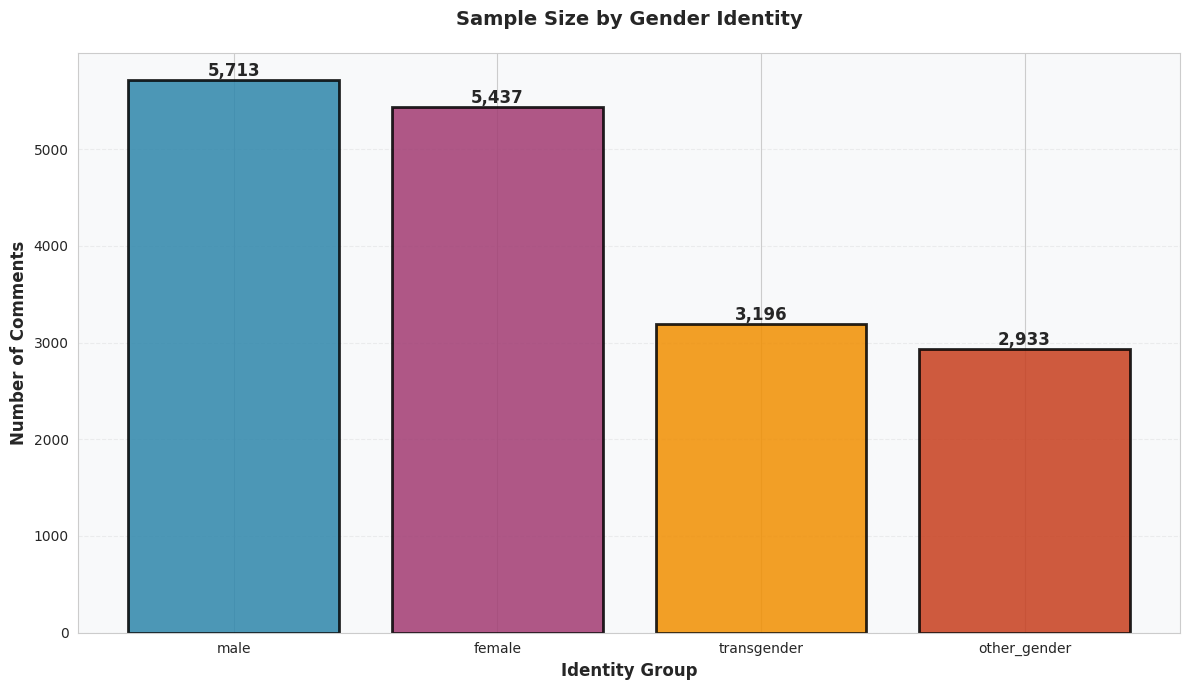

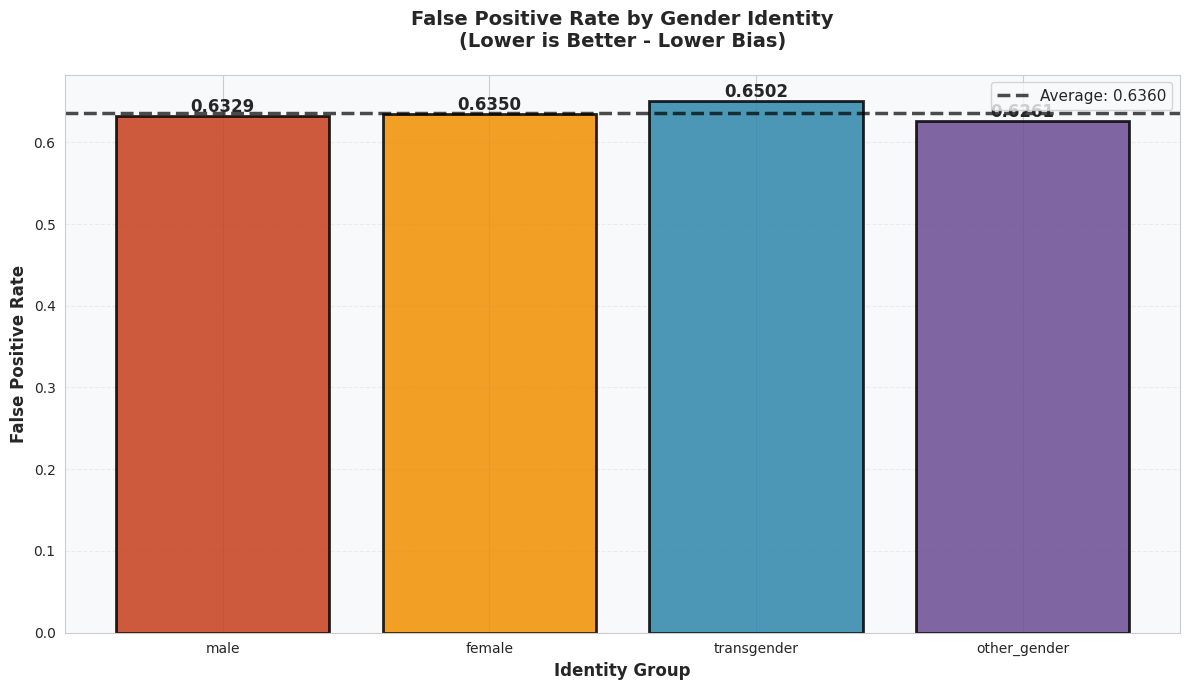

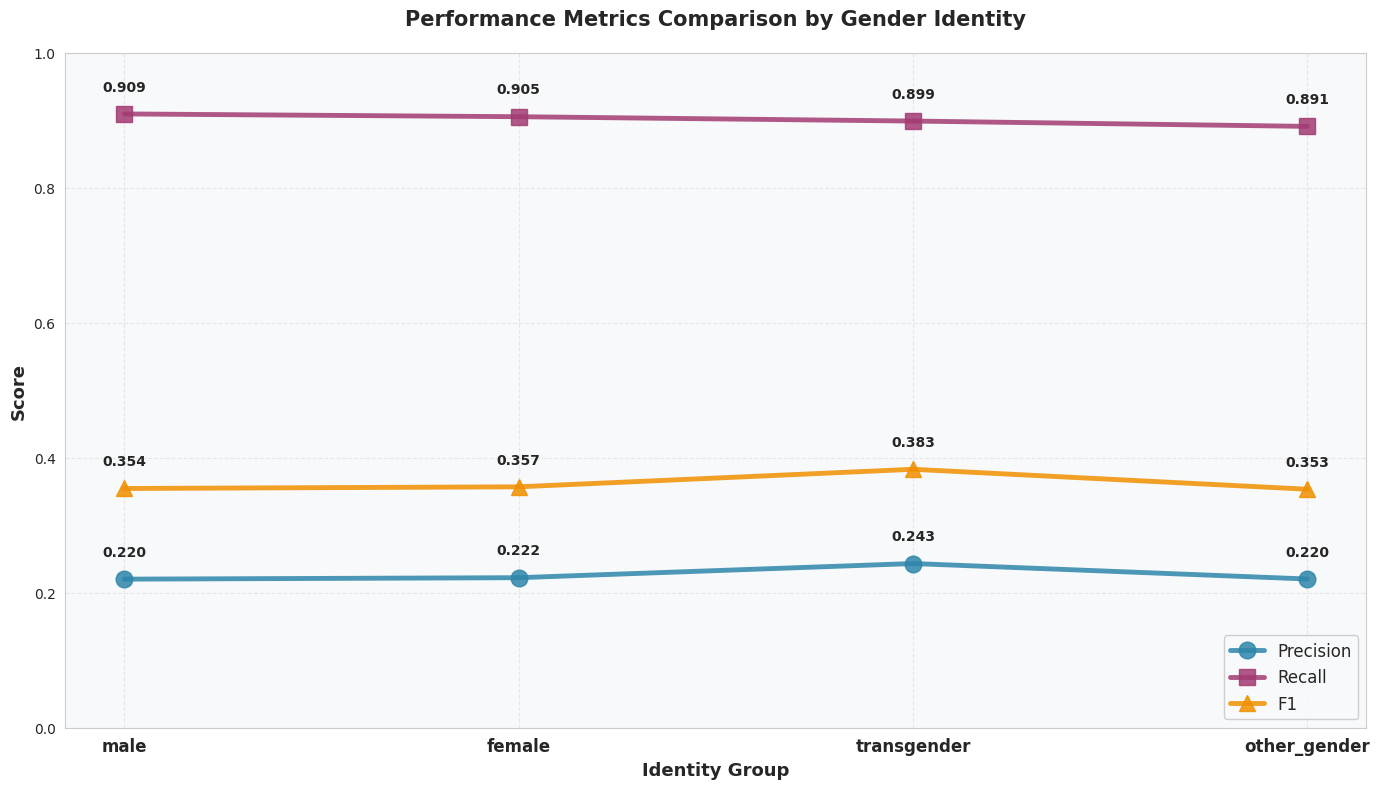


SUMMARY - GENDER DATASET

     Identity  Count  Precision   Recall       F1      FPR
        male   5713   0.220129 0.909382 0.354457 0.632880
      female   5437   0.222282 0.905286 0.356926 0.635019
 transgender   3196   0.243268 0.898839 0.382904 0.650212
other_gender   2933   0.220356 0.890947 0.353325 0.626073

✓ Visualizations saved for gender dataset:
  - twitter_sentiment_gender_sample_size.png
  - twitter_sentiment_gender_fpr_by_identity.png
  - twitter_sentiment_gender_metrics_line.png


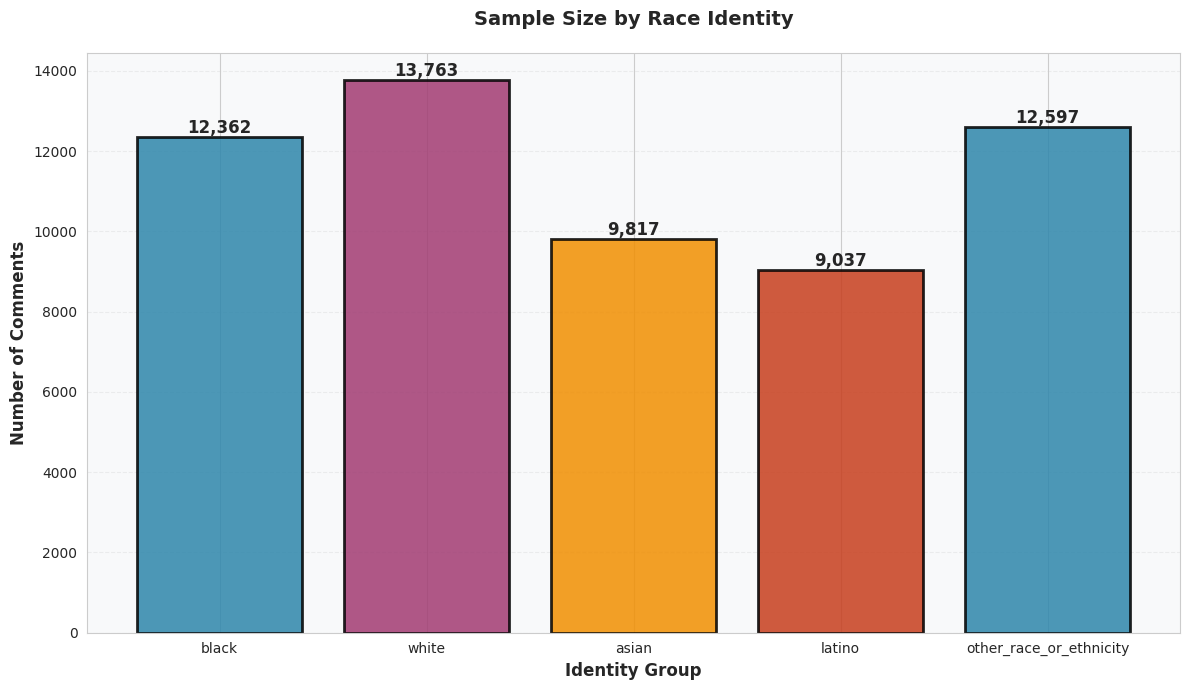

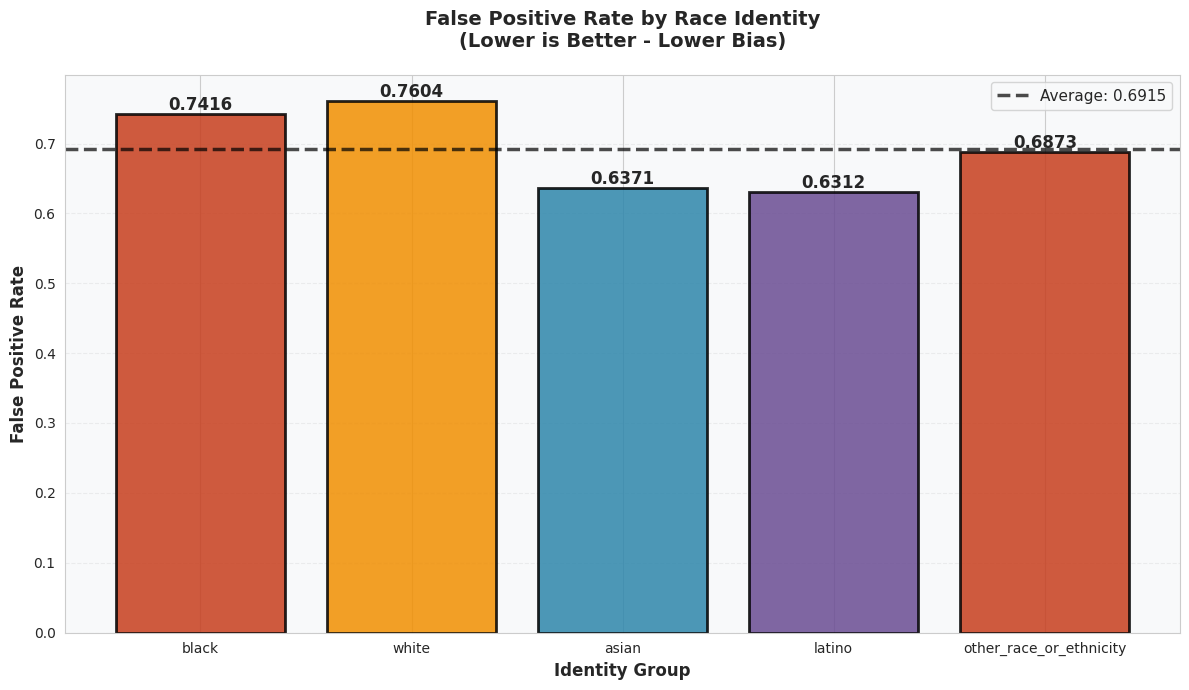

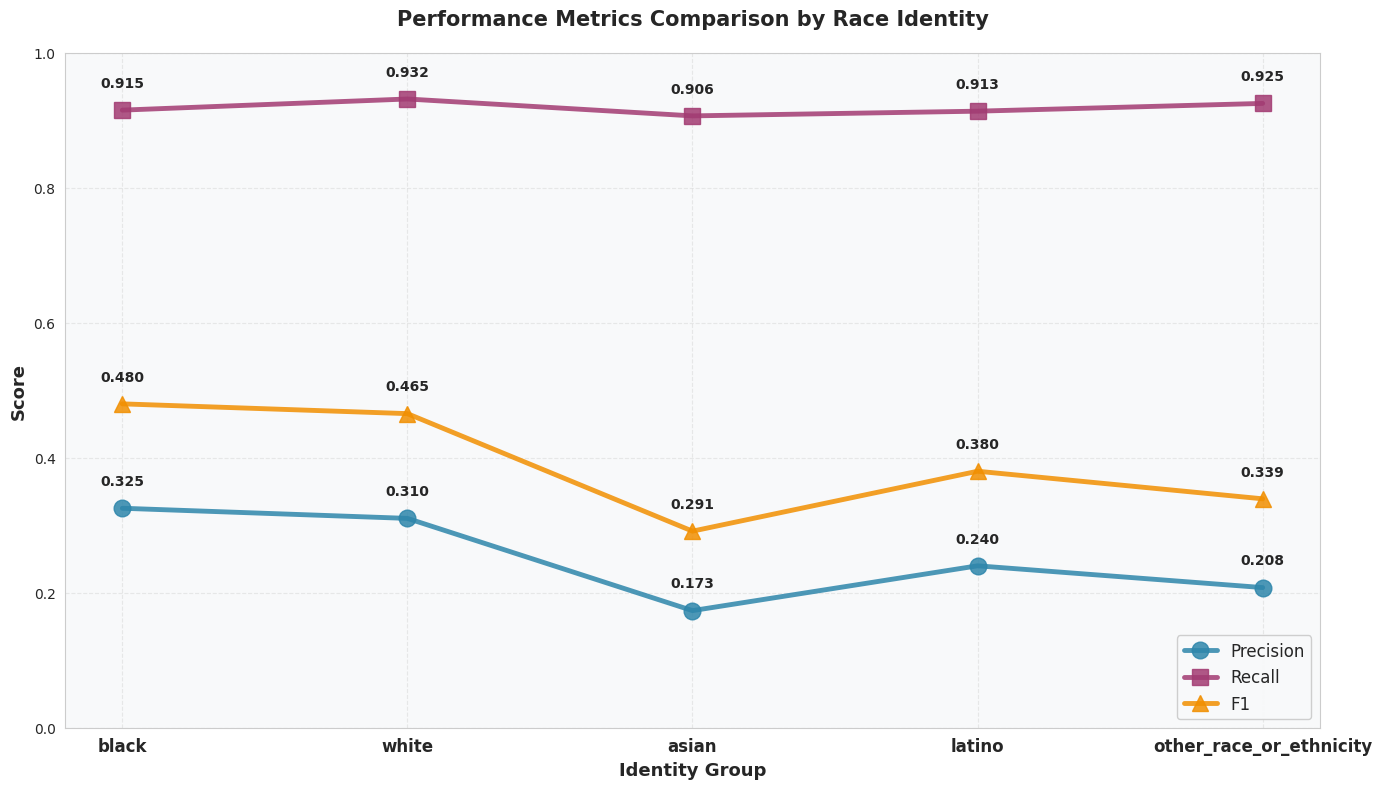


SUMMARY - RACE DATASET

                Identity  Count  Precision   Recall       F1      FPR
                  black  12362   0.325179 0.915035 0.479837 0.741620
                  white  13763   0.310146 0.931529 0.465355 0.760429
                  asian   9817   0.173491 0.906498 0.291242 0.637054
                 latino   9037   0.239896 0.913473 0.379997 0.631217
other_race_or_ethnicity  12597   0.207632 0.924988 0.339137 0.687310

✓ Visualizations saved for race dataset:
  - twitter_sentiment_race_sample_size.png
  - twitter_sentiment_race_fpr_by_identity.png
  - twitter_sentiment_race_metrics_line.png


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_identity_metrics(DATASET_TYPE):
    """
    DATASET_TYPE must be either 'gender' or 'race'
    and your files must be:
        twitter_sentiment_gender_metrics.csv
        twitter_sentiment_race_metrics.csv
    """

    # -------------------------- LOAD CSV --------------------------
    bias_df = pd.read_csv(f"twitter_sentiment_{DATASET_TYPE}_metrics.csv")

    # -------------------------- STYLE --------------------------
    sns.set_style("whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = '#f8f9fa'

    # -------------------------- SAMPLE SIZE BAR PLOT --------------------------
    fig, ax = plt.subplots(figsize=(12, 7))
    colors_sample = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'] * 3

    bars = ax.bar(
        bias_df['Identity'],
        bias_df['Count'],
        color=colors_sample[:len(bias_df)],
        alpha=0.85,
        edgecolor='black',
        linewidth=2
    )

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    ax.set_ylabel('Number of Comments', fontweight='bold', fontsize=12)
    ax.set_xlabel('Identity Group', fontweight='bold', fontsize=12)
    ax.set_title(f'Sample Size by {DATASET_TYPE.capitalize()} Identity',
                 fontweight='bold', fontsize=14, pad=20)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig(f"twitter_sentiment_{DATASET_TYPE}_sample_size.png", dpi=300, bbox_inches='tight')
    plt.show()

    # -------------------------- FPR BAR PLOT --------------------------
    fig, ax = plt.subplots(figsize=(12, 7))
    colors_fpr = ['#C73E1D', '#F18F01', '#2E86AB', '#6A4C93'] * 3

    bars = ax.bar(
        bias_df['Identity'], bias_df['FPR'],
        color=colors_fpr[:len(bias_df)],
        alpha=0.85,
        edgecolor='black', linewidth=2
    )

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}', ha='center', va='bottom',
                fontsize=12, fontweight='bold')

    overall_fpr = bias_df['FPR'].mean()
    ax.axhline(overall_fpr, color='black', linestyle='--', linewidth=2.5,
               label=f'Average: {overall_fpr:.4f}', alpha=0.7)

    ax.set_ylabel('False Positive Rate', fontweight='bold', fontsize=12)
    ax.set_xlabel('Identity Group', fontweight='bold', fontsize=12)
    ax.set_title(f'False Positive Rate by {DATASET_TYPE.capitalize()} Identity\n(Lower is Better - Lower Bias)',
                 fontweight='bold', fontsize=14, pad=20)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    plt.tight_layout()
    plt.savefig(f"twitter_sentiment_{DATASET_TYPE}_fpr_by_identity.png", dpi=300, bbox_inches='tight')
    plt.show()

    # -------------------------- METRICS LINE PLOT --------------------------
    fig, ax = plt.subplots(figsize=(14, 8))
    metrics_plot = ['Precision', 'Recall', 'F1']   # ❗ Accuracy removed
    colors_lines = ['#2E86AB', '#A23B72', '#F18F01']
    markers = ['o', 's', '^']
    x_pos = np.arange(len(bias_df))

    for i, metric in enumerate(metrics_plot):
        ax.plot(
            x_pos, bias_df[metric],
            marker=markers[i], markersize=12, linewidth=3.5,
            label=metric, color=colors_lines[i], alpha=0.85
        )

        for j, val in enumerate(bias_df[metric]):
            ax.text(j, val + 0.03, f'{val:.3f}', ha='center',
                    va='bottom', fontsize=10, fontweight='bold')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(bias_df['Identity'], fontsize=12, fontweight='bold')
    ax.set_ylabel('Score', fontweight='bold', fontsize=13)
    ax.set_xlabel('Identity Group', fontweight='bold', fontsize=13)
    ax.set_title(f'Performance Metrics Comparison by {DATASET_TYPE.capitalize()} Identity',
                 fontweight='bold', fontsize=15, pad=20)
    ax.legend(fontsize=12, loc='lower right', framealpha=0.95)
    ax.set_ylim(0.0, 1)
    ax.grid(True, alpha=0.4, linestyle='--')

    plt.tight_layout()
    plt.savefig(f"twitter_sentiment_{DATASET_TYPE}_metrics_line.png", dpi=300, bbox_inches='tight')
    plt.show()

    # -------------------------- SUMMARY TABLE --------------------------
    print("\n" + "="*80)
    print(f"SUMMARY - {DATASET_TYPE.upper()} DATASET")
    print("="*80)

    summary_table = bias_df[['Identity', 'Count', 'Precision', 'Recall', 'F1', 'FPR']].copy()
    summary_table['Count'] = summary_table['Count'].astype(int)

    print("\n", summary_table.to_string(index=False))

    print(f"\n✓ Visualizations saved for {DATASET_TYPE} dataset:")
    print(f"  - twitter_sentiment_{DATASET_TYPE}_sample_size.png")
    print(f"  - twitter_sentiment_{DATASET_TYPE}_fpr_by_identity.png")
    print(f"  - twitter_sentiment_{DATASET_TYPE}_metrics_line.png")


# ---- RUN FOR BOTH ----
plot_identity_metrics("gender")
plot_identity_metrics("race")
